In [1]:
#finalize notebook
#create pipeline for data processing
#Final Text Processing, changeable with input
# TF-IDF, KMean, Ward, top vectors
# Word2Vec, Kmean, Ward, top vectors
# LDA, 
#import
import re
import random
import sys
import numpy as np
import sqlite3
from operator import itemgetter
import hdbscan
from pprint import pprint
import pandas as pd #df
import matplotlib.pyplot as plt 
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
from scipy.cluster.hierarchy import dendrogram
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS #vectorizers & stop_words
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, AffinityPropagation #
from sklearn.externals import joblib
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import nltk
from nltk import text
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import gensim #w2v, lda
from gensim.models import word2vec
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

D:\Anaconda\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
D:\Anaconda\lib\site-packages\socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
D:\Anaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
#import data and review content
conn = sqlite3.connect('JobDBa.db')
cur = conn.cursor()
#25000 job descriptions at this time
cur.execute('SELECT * FROM [Jobs Indeed]')
data = cur.fetchall()
dfa = pd.DataFrame(data=data, columns=['Job Title', 'Company','Location','Description'])
print(dfa.describe())
dfa.isna().sum()

             Job Title                    Company      Location  \
count            25412                      25412         25412   
unique           16912                       8681          1349   
top     Data Scientist  Amazon.com Services, Inc.  New York, NY   
freq               529                        513          1018   

                                              Description  
count                                               25412  
unique                                              25412  
top     Job Description: **Mandatory Skills: Scala, Sp...  
freq                                                    1  


Job Title      0
Company        0
Location       0
Description    0
dtype: int64

In [3]:
dfs = dfa.sample(frac=.15) #subset data we will be working with
stemmer = SnowballStemmer('english')

In [4]:
#function that takes list of documents and determines stop_words to add based on conditions
#text variable must be dataframe
def text_process(texts, clean=True, pos=True, sentence=True, **kwargs):
    corpus = texts.Description.values #init corpus, unmodified description
    #remove repeating sentences
    if sentence is True:
        tv = CountVectorizer(tokenizer=sent_tokenize)
        tmat =tv.fit_transform(texts)
        tf = tv.get_feature_names()
        tmata = tmat.toarray()
        tmatat = tmata.transpose()
        tl = []
        for item,name in zip(tmatat, tf):
            tl.append([name, item.mean()])
        newl = []
        for item in tl:
            if item[1] >= ((1/len(texts.Description.values))*1.1):
                newl.append(item)
        nono = []
        for item in newl:
            reg = re.search('[ ]', item[0])
            if reg is None:
                nono.append(item)
        nnl = [n for n in newl if n not in nono]
        ccorpus = []
        for desc in texts.Description.values:
            sent = sent_tokenize(desc)
            nxt = [u for u in sent if u not in nnl]
            string = ''.join(nxt)
            ccorpus.append(string)
        corpus= ccorpus
    else:
        print('sentence=false')
    #clean \n and misaligned words
    if clean is True:
        ccorpus = []
        for txt in corpus:
            nre = re.sub(r"(\n)", r" ", txt) #remove "\n" characters
            cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
            cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
            ccorpus.append(cap)
        corpus = ccorpus
    else:
        print('clean=false')
    #remove adjectives, adverbs, prepositions etc., unnecessary POS tagging
    if pos is True:
        ccorpus = []
        for txt in corpus:
            tokenize = nltk.wordpunct_tokenize(txt)
            pos_tag = nltk.pos_tag(tokenize)
            remove = ['PRP$','WP$','WP','WRB','WDT','UH','TO','RP','RBS','RBR','RB','PRP','MD','LS','JJS','JJ','JJR','FW','IN','DT','CC']
            out = []
            for tok in pos_tag:
                if tok[1] in remove:
                    pass
                else:
                    out.append(tok[0])
            string = ' '.join(out)
            ccorpus.append(string)
        corpus=ccorpus
    return corpus

def set_stop(corpus, df, add=True, punc=True, loc=True, num=True, company=True, max_df=0.8, min_df=.02, *args, **kwargs):
    #set stop_words
    stop_words = ENGLISH_STOP_WORDS
    stopw = nltk.corpus.stopwords.words('english') #add additional stop words
    stop_words = stop_words.union(stopw) #add punc removal
    #add stop_words unable to be filtered out from other means
    if add is True:
        add_stop=['lab','laboratory','company','inc','technology','computer','institute','public','\r','connect','people','fb','g','ge',
                  'accomadate','sexuality','sex','orientation','orient','gender','race','ethnicity','ethnic','equal','opportunity','minor',
                  'disable','veteran','female','male','employer','employee','network','require','affirm','jp','jpmorgan','chase','usa','america','canada',
                  'career','job','compani', 'work','location','origin','religion','ident','sexual','color','identity','nation','national',
                 'disability','protect','protected','background','screening','screen','drug','diversity','diverse','employment',
                 'employ','affirimative','action','applicant','discrimination','discriminate','apply','application', 'resume','agency','agent',
                 '\r \r', 'proud','inclusive','inclusion','recruit','recruitment','recruiter','hire','submit','agree','agreement',
                 'marital', 'status', 'marriage', 'help','require','perform','duty','duti','provide','accomod', 'authorization','author',
                 'type','time','salary', '00','000 00', '000', 'citizenship','citizen','large','identify','crime','criminal', 
                 'ancestry', "you're","you'r","we're","we'r", 'minority','abuse', 'affirm', 'united', 'states', 'province', 'shift',
                 '’','skill','ability', 'skills','role', 'assist'] #removal of stop-words that were unable to be filtered out from other methods
        stop_words = stop_words.union(add_stop)
    else:
        print('add=false')
    #remove punc not captured by regex
    if punc is True:
        punct = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'",'-','>','<','/','^', ''] 
        stop_words = stop_words.union(punct)
    else:
        print('punc=false')
    #remove numbers 1 through 10 from stopword removal - keep years experience desired
    if num is True:
        sw = [n for n in stop_words]
        for i in range(1,10):
            itn = str(i)
            try:
                sw == sw.remove(itn)
            except:
                pass
        stop_words = frozenset(sw)
    else:
        print('num=false')
    
    #remove company names
    if company is True:
        comp = df.Company.values
        pcom = []
        for item in comp:
            pcom.append(item.lower())
        pnd = list(set(pcom))
        stop_words = stop_words.union(pnd)
    else:
        print('company=false')
    #location removal
    if loc is True:
        location = df.Location.values
        pcom = []
        for item in location:
            w = wordpunct_tokenize(item)
            for itr in w:
                pcom.append(itr.lower())
        pnd = list(set(pcom))
        stop_words = stop_words.union(pnd)
    else:
        print('company=false')
    #add stop_words based on document frequency cutoffs
    cv = CountVectorizer(max_df = max_df, min_df = min_df, stop_words=stop_words, tokenizer=wordpunct_tokenize)
    cvm = cv.fit(corpus)
    swp = cv.stop_words_
    stop_words = stop_words.union(swp)
    #remove recurring sentences
    return stop_words

#call after processing
def gg_tokenize(text):
    nre = re.sub(r"(\n)", r" ", text) #remove "\n" characters
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap) #remove punctuation by replacing with space, allows tokenize to occur more effectively
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower()) #tokenize based on any left over punctuation or spaces
    h = [n for n in tok if not n in stop_words] #remove stop_words after tokenization, leftovers will be removed with stem stop_words
    stem = [stemmer.stem(word) for word in h]   #stem words after stop_word removal and tokenization
    return stem


In [5]:
#Feature generation with TF-IDF
def tfidf_get(corpus, stop_words, tokenizer, max_df=.8, min_df=.02, **kwargs):
    tfidf = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, tokenizer=tokenizer)
    tmatrix = tfidf.fit_transform(corpus)
    ftn = tfidf.get_feature_names()
    return tfidf, tmatrix, ftn

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector


def averaged_word_vectorizer(token, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in token]
    return np.array(features)

#Feature engineer through word embedding
def w2v_get(token, feature_size=50, window_context=12,min_word_count=2,sample=1e-3, itr=40,**kwargs):
    w2v_model = word2vec.Word2Vec(token, size=feature_size, window=window_context, min_count = min_word_count, sample=sample, iter=itr)
    w2v_feature_array = averaged_word_vectorizer(token=token, model=w2v_model, num_features=feature_size)
    return w2v_feature_array
    

#Feature Engineer with LDA, Topic Modeling
def lda_get(corpus, num_topics=20, random_state=100, update_every=1, 
           chunksize=100,passes=20, alpha='auto',per_word_topics=True, **kwargs):
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]

    lda_model = gensim.models.ldamodel.LdaModel(corpus=tdf,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=random_state,
                                               update_every=update_every,
                                               chunksize=chunksize,
                                               passes=passes,
                                               alpha=alpha,
                                               per_word_topics=per_word_topics)
    return lda_model


In [6]:
#kmean clustering
def kmeans(matrix, n_clusters=10, **kwargs):
    km = KMeans(n_clusters=n_clusters)
    km.fit(matrix)
    dfk = dfs.copy()
    dfk['Cluster Label'] =km.labels_
    return km, dfk
#Ward linkage agglomerative clustering
def ward(matrix, n_clusters=10, **kwargs):
    agc = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward',affinity='euclidean')
    agc.fit_predict(matrix.todense())
    dfw = dfs.copy()
    dfw['Cluster Label'] =km.labels_
    return agc, dfw
#elbow method test optimal k
def elbow(matrix, rnge):
    ssd = []
    sil = []
    sil_samp = []
    for n in range(rnge):
        km = KMeans(n_clusters=n)
        km.fit(matrix)
        ssd.append(km.inertia_)
        sil_avg = silhouette_score(matrix, km.labels_)
        samp_sil = silhouette_samples(matrix, km.labels_)
        sil.append(sil_avg)
        sil_samp.append(samp_sil)
    return ssd, sil, sil_samp
#graph clusters in 2-D space, choose dimensionality reduction technique    
def graph_cluster(matrix, df, dim='t-SNE', **kwargs):
    dist = 1-cosine_similarity(matrix)
    dfg = df.copy()
    cond = 0
    if dim=='t-SNE':
        tsne = TSNE(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    elif dim=='PCA':
        tsne = PCA(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    elif dim=='MDS':
        tsne = MDS(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    else:
        'Dimensionality reduction tool not available. Please choose "t-SNE","PCA", or "MDS"'
        cond=1
    if cond ==1:
        pass
    else:
        plt.figure(figsize=(16,12))
        sns.scatterplot(x='Dim-1', y='Dim-2', data=dfg, hue='Cluster Label', legend='full', palette='nipy_spectral_r')
        plt.show()
    return dfg
#determine top TF-IDF vectors in each cluster
def centroid_vector(model, ftn, top=20, **kwargs):
    order_centroid = model.cluster_centers_.argsort()[:, ::-1] 
    cent_top = {}
    for i in range(len(order_centroid)):
        values= []
        for ind in order_centroid[i, :top]: #replace 6 with n words per cluster
            values.append(ftn[ind])
        cent_top[i] = values
    return cent_top
# Top count vectorizer in each cl  
def conv_top(corpus, df, stop_words, max_df=.8, min_df=.02, top=30, **kwargs):
    cluster_top_vectors = {}
    cv = CountVectorizer(max_df=.8, min_df=.02, stop_words=stop_words,tokenizer = wordpunct_tokenize)
    cvm = cv.fit_transform(corpus)
    for i in range(0,len(df['Cluster Label'].unique())):
        dfc = df.loc[df['Cluster Label'] ==i]
        lab = df.index.tolist()
        crn = cvm.toarray()
        labelem = []
        for item, l in zip(crn, lab):
            labelem.append([l,item])
        l1 = [n for n in labelem if n[0] in dfc.index]
        newm = []
        for item in l1:
            newm.append(item[1])
        newmt = np.array(newm).transpose()
        topv = []
        for item,name in zip(newmt,cv.get_feature_names()):
            mn = item.mean()
            topv.append([name,mn])
        topvs = sorted(topv, key=itemgetter(1), reverse=True)
        topn = []
        for item in topvs[0:top]:
            topn.append(item[0])
        cluster_top_vectors[i]=topn
    return cluster_top_vectors
    


In [7]:
corpus = text_process(dfs)
stop_words = set_stop(corpus, dfs)
stem_stop = [stemmer.stem(word) for word in stop_words]

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['".', "')", "('", '+', '--', '.)', '.,', '1910', '20', '212', '214', '5', '51', '59', '66', '7', '7ac', '8', '84', '8th', '8x8', '9th', '://', '`', 'a100', 'a2z', 'a9', 'aaa', 'abbott', 'abbvie', 'abercrombie', 'abt', 'ac', 'acacia', 'academy', 'access', 'acco', 'accolade', 'ace', 'act', 'ad', 'adaptive', 'adara', 'adbakx', 'adcolony', 'adidev', 'admin', 'administration', 'adroiti', 'aduro', 'adva', 'advanced', 'adventist', 'adventures', 'advertise', 'advertising', 'advisors', 'advisory', 'aegis', 'aera', 'aerospace', 'aether', 'agar', 'agat', 'age', 'agents', 'agile', 'agitare', 'agriculture', 'ahp', 'ai', 'aid', 'air', 'airbus', 'aircraft', 'airgas', 'airlines', 'airspace', 'akraya', 'alameda', 'alamere', 'alaska', 'albertsons', 'alchemy', 'alexion', 'allen', 'alliance', 'allianz', 'ally', 'alom', '

In [8]:
#tfidf kmean
tfidf, tmatrix, ftn = tfidf_get(corpus, stem_stop, gg_tokenize)
km, dfk = kmeans(tmatrix)

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['"–', '0', '000003', '000004', '000071', '000075', '000300', '0011368', '0056', '00974', '009746', '01362', '01486', '01565p', '0157', '01782', '026203f3vbqbv7loqw0b', '02631', '041', '0419', '05102019web', '056', '057', '059', '06320', '06s', '072216', '0c', '0s7lc8ddmpbw2n0x6l2b9nmjw7t5xzs2zgcjzw8rbgyz3r2nnxf3m', '0x1', '1', '10', '100', '1062801', '10949', '11', '110a', '1116182b11', '112r', '116', '12', '123job', '126aw', '134', '13665', '14', '14576usen', '150sw', '15675br', '1647', '18', '1ajjpm0u', '1b', '1cygph1zseoc6ln', '1d', '1dbboard', '1dbdetermin', '1dhreotth6idvjj', '1lab', '1m', '1u0usycgfimrz', '1x1', '2', '20', '2017', '202111', '2050r', '211mn', '24', '25', '27000', '27036', '27xxx', '2b', '2c', '2cash', '2e2', '2ee', '2f', '2hp4', '2o', '2open', '2p0s19', '2r', '2s', '2vec', '3', '

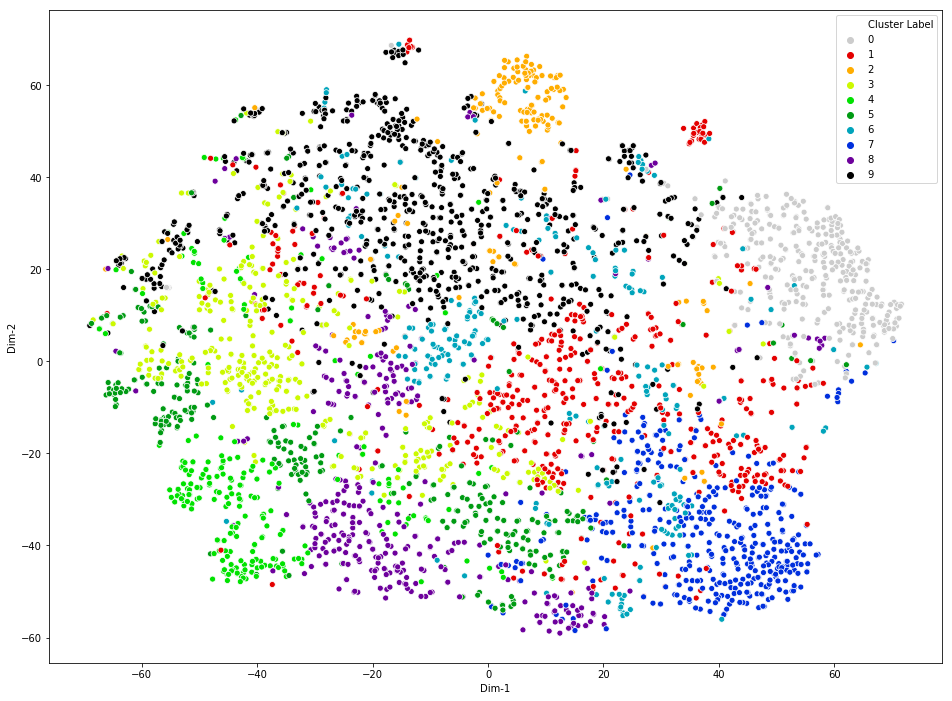

In [9]:
dfg = graph_cluster(tmatrix, dfk)

In [10]:
centroid_vec = centroid_vector(km, ftn)
top_count_vec = conv_top(corpus, dfk, stop_words)
for x,y in zip(centroid_vec.items(), top_count_vec.items()):
    print(x[0])
    print(x[1])
    print(y[1])
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["')", '+', '.)', '.,', '20', '5', '7', '7ac', '8', '9th', '://', 'a100', 'a2z', 'access', 'act', 'ad', 'adbakx', 'administration', 'advanced', 'advertising', 'aegis', 'age', 'agile', 'ai', 'air', 'airgas', 'alamere', 'alchemy', 'alphabyte', 'alta', 'amazon', 'ambernet', 'analysis', 'analytics', 'app', 'applications', 'applied', 'apps', 'arbella', 'archaeological', 'architects', 'aricent', 'art', 'artis', 'aspects', 'aspnet', 'assets', 'associated', 'associates', 'assurance', 'automation', 'avery', 'b', 'bank', 'bdp', 'bedding', 'behavior', 'benefit', 'benefits', 'best', 'big', 'biomachines', 'board', 'bobrick', 'bottlers', 'brand', 'brands', 'brothers', 'budget', 'business', 'caban', 'california', 'campaign', 'cana', 'capax', 'capital', 'care', 'careers', 'case', 'caspian', 'cell', 'centers', 'change'

0
['client', 'busi', 'year', 'problem', 'analysi', 'make', 'deliv', 'creat', 'strategi', 'lead', 'offer', 'day', 'candid', '1', 'meet', 'relationship', '–', 'drive', 'member', 'written']
['client', 'clients', 'business', 'management', 'solutions', 'analytics', 'development', 'project', 'support', 'working', 'knowledge', 'services', 'required', 'including', 'years', 'analysis', 'projects', 'requirements', 'environment', 'information', 'design', 'research', 'teams', 'software', 'opportunities', 'develop', 'customer', 'degree', 'tools', 'world']

1
['busi', 'lead', 'strategi', 'drive', 'creat', 'make', 'growth', 'year', 'deliv', 'problem', 'goal', 'meet', 'campaign', 'com', 'stakehold', 'leader', 'communiti', 'way', '–', 'e']
['business', 'management', 'product', 'development', 'customer', 'solutions', 'marketing', 'support', 'teams', 'working', 'design', 'customers', 'world', 'years', 'including', 'sales', 'knowledge', 'software', 'environment', 'products', 'build', 'develop', 'engineeri

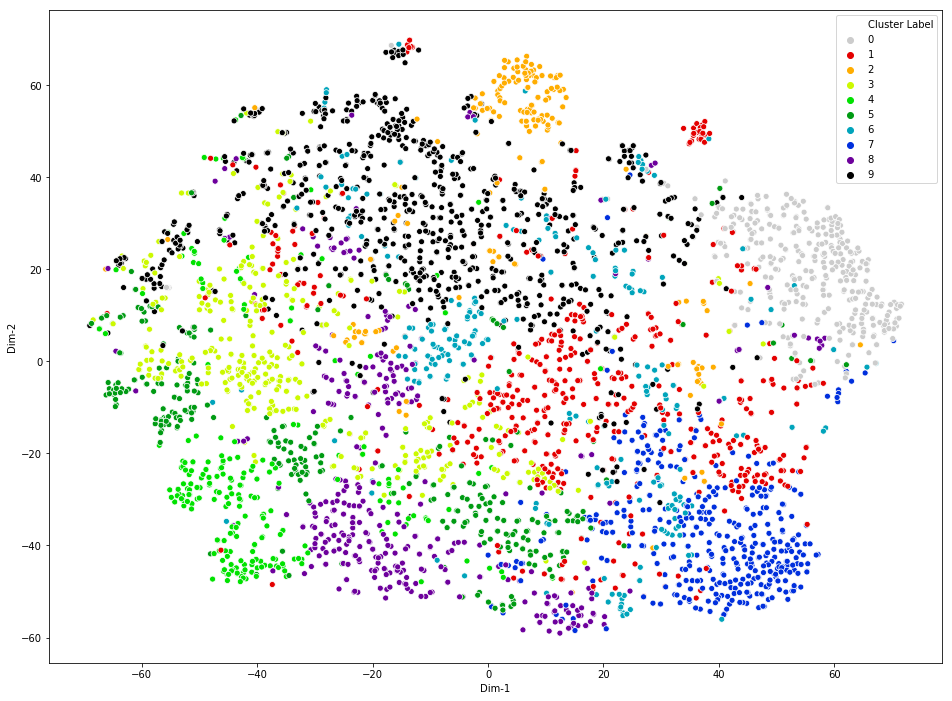

In [11]:
agc, dfw = ward(tmatrix)
dfg = graph_cluster(tmatrix, dfw)

In [12]:
top_count_vec = conv_top(corpus, dfw, stop_words)
for x in top_count_vec.items():
    print(x[0])
    print(x[1])
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["')", '+', '.)', '.,', '20', '5', '7', '7ac', '8', '9th', '://', 'a100', 'a2z', 'access', 'act', 'ad', 'adbakx', 'administration', 'advanced', 'advertising', 'aegis', 'age', 'agile', 'ai', 'air', 'airgas', 'alamere', 'alchemy', 'alphabyte', 'alta', 'amazon', 'ambernet', 'analysis', 'analytics', 'app', 'applications', 'applied', 'apps', 'arbella', 'archaeological', 'architects', 'aricent', 'art', 'artis', 'aspects', 'aspnet', 'assets', 'associated', 'associates', 'assurance', 'automation', 'avery', 'b', 'bank', 'bdp', 'bedding', 'behavior', 'benefit', 'benefits', 'best', 'big', 'biomachines', 'board', 'bobrick', 'bottlers', 'brand', 'brands', 'brothers', 'budget', 'business', 'caban', 'california', 'campaign', 'cana', 'capax', 'capital', 'care', 'careers', 'case', 'caspian', 'cell', 'centers', 'change'

0
['client', 'clients', 'business', 'management', 'solutions', 'analytics', 'development', 'project', 'support', 'working', 'knowledge', 'services', 'required', 'including', 'years', 'analysis', 'projects', 'requirements', 'environment', 'information', 'design', 'research', 'teams', 'software', 'opportunities', 'develop', 'customer', 'degree', 'tools', 'world']

1
['business', 'management', 'product', 'development', 'customer', 'solutions', 'marketing', 'support', 'teams', 'working', 'design', 'customers', 'world', 'years', 'including', 'sales', 'knowledge', 'software', 'environment', 'products', 'build', 'develop', 'engineering', 'information', 'process', 'learning', 'analytics', 'projects', 'services', 'growth']

2
['health', 'care', 'healthcare', 'research', 'management', 'support', 'information', 'business', 'required', 'including', 'years', 'development', 'analysis', 'quality', 'knowledge', 'services', 'position', 'working', 'environment', 'degree', 'requirements', 'systems', 'pro

In [13]:
#different tokenizers 
wpt = nltk.WordPunctTokenizer()
wpt_corpus =[wpt.tokenize(document) for document in corpus]
gg_corpus = [gg_tokenize(document) for document in corpus]

In [14]:
#get w2vwpt
wpt2v_array = w2v_get(wpt_corpus)
kmwp2, dfkwp2 = kmeans(wpt2v_array)
# agwp2, dfagwp2 = ward(wpt2v_array)

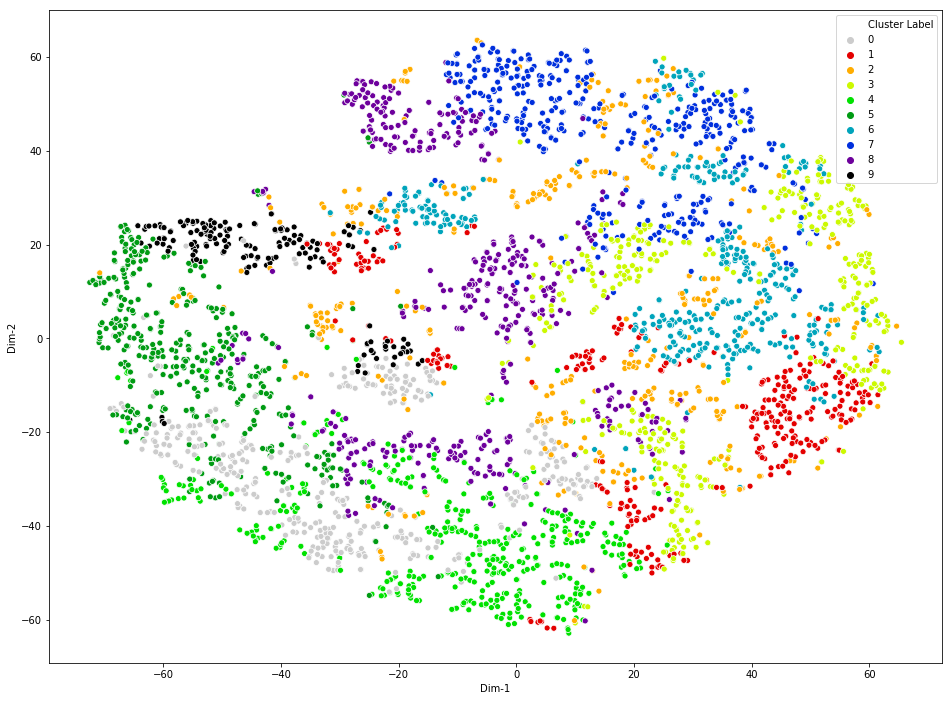

In [15]:
dfg = graph_cluster(wpt2v_array, dfkwp2)

In [16]:
wpt_top = conv_top(corpus, dfkwp2, stop_words)
for key, value in wpt_top.items():
    print(key)
    print(value)
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["')", '+', '.)', '.,', '20', '5', '7', '7ac', '8', '9th', '://', 'a100', 'a2z', 'access', 'act', 'ad', 'adbakx', 'administration', 'advanced', 'advertising', 'aegis', 'age', 'agile', 'ai', 'air', 'airgas', 'alamere', 'alchemy', 'alphabyte', 'alta', 'amazon', 'ambernet', 'analysis', 'analytics', 'app', 'applications', 'applied', 'apps', 'arbella', 'archaeological', 'architects', 'aricent', 'art', 'artis', 'aspects', 'aspnet', 'assets', 'associated', 'associates', 'assurance', 'automation', 'avery', 'b', 'bank', 'bdp', 'bedding', 'behavior', 'benefit', 'benefits', 'best', 'big', 'biomachines', 'board', 'bobrick', 'bottlers', 'brand', 'brands', 'brothers', 'budget', 'business', 'caban', 'california', 'campaign', 'cana', 'capax', 'capital', 'care', 'careers', 'case', 'caspian', 'cell', 'centers', 'change'

0
['systems', 'support', 'engineering', 'design', 'management', 'knowledge', 'development', 'required', 'software', 'test', 'business', 'requirements', 'years', 'including', 'quality', 'project', 'information', 'process', 'solutions', 'testing', 'equipment', 'security', 'environment', 'analysis', 'working', 'customer', 'projects', 'issues', 'position', 'operations']

1
['business', 'analytics', 'learning', 'years', 'solutions', 'tools', 'design', 'science', 'development', 'analysis', 'machine', 'knowledge', 'working', 'sql', 'models', 'engineering', 'using', 'develop', 'management', 'python', 'systems', 'modeling', 'build', 'support', 'teams', 'technologies', 'software', 'aws', 'services', 'building']

2
['development', 'software', 'learning', 'engineering', 'science', 'business', 'systems', 'design', 'research', 'years', 'solutions', 'machine', 'working', 'including', 'knowledge', 'required', 'world', 'analysis', 'technologies', 'information', 'tools', 'environment', 'analytics', 'man

In [17]:
#get w2vgg
gg_array = w2v_get(gg_corpus)
kmgg, dfkgg = kmeans(gg_array)
# aggg, dfagg = ward(gg_array)

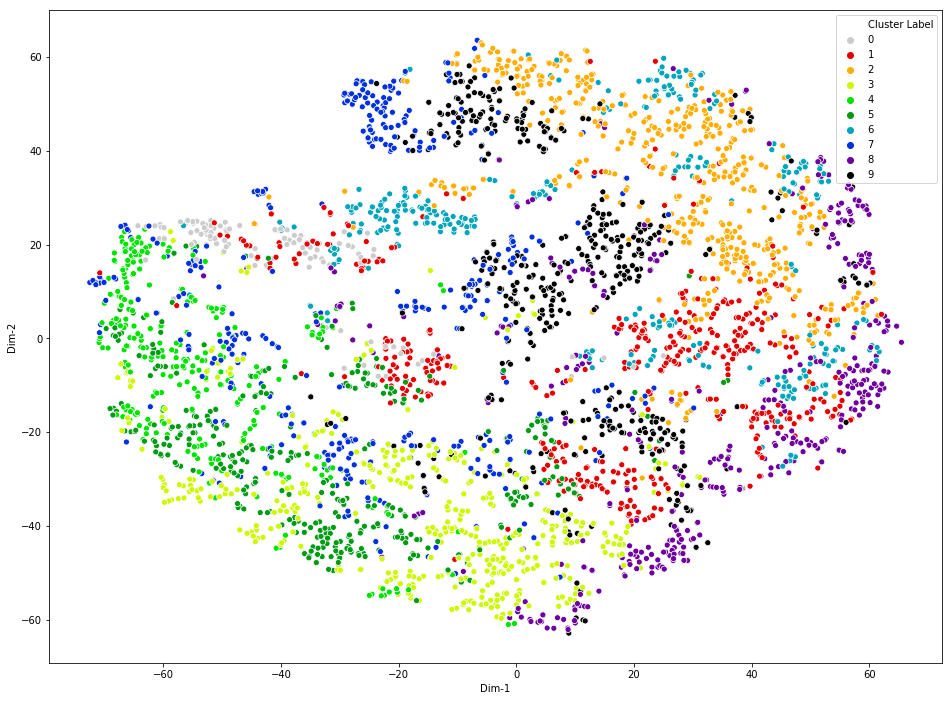

In [18]:
dfg = graph_cluster(wpt2v_array, dfkgg)

In [19]:
wpt_top = conv_top(corpus, dfkgg, stop_words)
for key, value in wpt_top.items():
    print(key)
    print(value)
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["')", '+', '.)', '.,', '20', '5', '7', '7ac', '8', '9th', '://', 'a100', 'a2z', 'access', 'act', 'ad', 'adbakx', 'administration', 'advanced', 'advertising', 'aegis', 'age', 'agile', 'ai', 'air', 'airgas', 'alamere', 'alchemy', 'alphabyte', 'alta', 'amazon', 'ambernet', 'analysis', 'analytics', 'app', 'applications', 'applied', 'apps', 'arbella', 'archaeological', 'architects', 'aricent', 'art', 'artis', 'aspects', 'aspnet', 'assets', 'associated', 'associates', 'assurance', 'automation', 'avery', 'b', 'bank', 'bdp', 'bedding', 'behavior', 'benefit', 'benefits', 'best', 'big', 'biomachines', 'board', 'bobrick', 'bottlers', 'brand', 'brands', 'brothers', 'budget', 'business', 'caban', 'california', 'campaign', 'cana', 'capax', 'capital', 'care', 'careers', 'case', 'caspian', 'cell', 'centers', 'change'

0
['years', 'required', 'preferred', 'development', 'year', '1', 'knowledge', '5', 'sql', 'software', 'systems', '2', '3', 'science', 'design', 'working', 'management', 'using', 'engineering', 'python', 'business', 'degree', 'programming', 'analysis', 'tools', 'education', 'learning', '4', 'java', 'hadoop']

1
['development', 'software', 'business', 'design', 'solutions', 'systems', 'knowledge', 'management', 'years', 'engineering', 'tools', 'technologies', 'working', 'services', 'support', 'requirements', 'test', 'including', 'cloud', 'applications', 'science', 'architecture', 'teams', 'environment', 'testing', 'develop', 'sql', 'using', 'aws', 'security']

2
['software', 'development', 'engineering', 'business', 'design', 'world', 'solutions', 'working', 'learning', 'product', 'build', 'systems', 'building', 'customers', 'years', 'services', 'science', 'teams', 'machine', 'technologies', 'cloud', 'products', 'environment', 'platform', 'engineers', 'including', 'looking', 'make', 'too

In [20]:
lad = lda_get(gg_corpus)

In [21]:
lad.print_topics()

[(0,
  '0.080*"secur" + 0.046*"support" + 0.041*"servic" + 0.037*"system" + 0.030*"infrastructur" + 0.027*"manag" + 0.026*"custom" + 0.023*"environ" + 0.022*"engin" + 0.022*"oper"'),
 (1,
  '0.105*"engin" + 0.040*"design" + 0.036*"equip" + 0.028*"safeti" + 0.027*"oper" + 0.023*"project" + 0.022*"manufactur" + 0.020*"system" + 0.018*"construct" + 0.018*"requir"'),
 (2,
  '0.043*"amazon" + 0.042*"build" + 0.042*"engin" + 0.032*"aw" + 0.029*"pipelin" + 0.027*"platform" + 0.024*"servic" + 0.021*"system" + 0.020*"cloud" + 0.019*"spark"'),
 (3,
  '0.074*"databas" + 0.070*"sql" + 0.053*"report" + 0.039*"busi" + 0.033*"tool" + 0.032*"intellig" + 0.028*"use" + 0.027*"bi" + 0.026*"warehous" + 0.026*"queri"'),
 (4,
  '0.197*"market" + 0.118*"sale" + 0.063*"media" + 0.049*"brand" + 0.035*"content" + 0.034*"campaign" + 0.028*"advertis" + 0.028*"channel" + 0.026*"insight" + 0.025*"strategi"'),
 (5,
  '0.100*"learn" + 0.085*"machin" + 0.035*"model" + 0.028*"scienc" + 0.025*"algorithm" + 0.024*"ml" + 